In [1]:
import xarray as xr
import zarr
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import data_module_norm as dm
#import train_callbacks as tc
import dask
import torch

with open("config_norm.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
        
def find_nearest_idx(
    arr1: np.ndarray,
    arr2: np.ndarray,
    val1: float,
    val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second arrat
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    return (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()


def transform(x, mean, std):
    x_norm = (x - mean) / (std + 1e-5)
    return x_norm


def invtransform(x, mean, std):
    x_norm = (x * (std + 1e-5)) + mean
    return x_norm

#ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
#ds["data"][0]

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

/perm/daep/conda/envs/ml-tt/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
test_ds = dm.EcDataset(
    start_yr=2022,
    end_yr=2022,
    x_idxs=(500, 500 + 2),
    # path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr",
    path="/hpcperm/daep/ecland_i6aj_2017_2022_1h_subset.zarr",
    # x_idxs=(9973, 9973 + 1),
    # # path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6h.zarr"
    # path="/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i8ki_o200_2010_2022_6h.zarr",
)

setting clim_clake normalisation=none, mean=0.0, stdev=1.0
setting clim_ldepth normalisation=none, mean=0.0, stdev=1.0
setting clim_ctype normalisation=none, mean=0.0, stdev=1.0
setting clim_landsea normalisation=none, mean=0.0, stdev=1.0
setting clim_glm normalisation=none, mean=0.0, stdev=1.0
setting clim_cu normalisation=none, mean=0.0, stdev=1.0
setting clim_cvh normalisation=none, mean=0.0, stdev=1.0
setting clim_cvl normalisation=none, mean=0.0, stdev=1.0
setting clim_geopot normalisation=mean-std, mean=5893.30419921875, stdev=7039.576171875
setting clim_sdfor normalisation=mean-std, mean=46.821895599365234, stdev=63.88310241699219
setting clim_sdor normalisation=mean-std, mean=94.92144012451172, stdev=127.35152435302734
setting clim_theta_cap normalisation=none, mean=0.0, stdev=1.0
setting clim_theta_pwp normalisation=none, mean=0.0, stdev=1.0
setting clim_veg_covh normalisation=none, mean=0.0, stdev=1.0
setting clim_veg_covl normalisation=none, mean=0.0, stdev=1.0
setting clim_

In [7]:
test_ds.x_static_scaled.shape

torch.Size([1, 2, 19])

In [3]:
CONFIG["normalize"]

{'default': ['mean-std'],
 'max': ['snowc_recalc', 'tsn', 'lai_hv', 'lai_lv'],
 'none': ['clim_clake',
  'clim_ldepth',
  'clim_ctype',
  'clim_landsea',
  'clim_glm',
  'clim_cu',
  'clim_cvh',
  'clim_cvl',
  'clim_theta_cap',
  'clim_theta_pwp',
  'clim_veg_covh',
  'clim_veg_covl',
  'swvl1',
  'swvl2',
  'swvl3'],
 'stdev': ['sd']}

In [4]:
all_feats = CONFIG["clim_feats"] + CONFIG["dynamic_feats"] + CONFIG["targets_prog"] + CONFIG["targets_diag"]
all_feats

clim_feats = [item.keys() for item in CONFIG["clim_feats"]]
clim_feats

[dict_keys(['clim_clake']),
 dict_keys(['clim_ldepth']),
 dict_keys(['clim_ctype']),
 dict_keys(['clim_landsea']),
 dict_keys(['clim_glm']),
 dict_keys(['clim_cu']),
 dict_keys(['clim_cvh']),
 dict_keys(['clim_cvl']),
 dict_keys(['clim_geopot']),
 dict_keys(['clim_sdfor']),
 dict_keys(['clim_sdor']),
 dict_keys(['clim_theta_cap']),
 dict_keys(['clim_theta_pwp']),
 dict_keys(['clim_veg_covh']),
 dict_keys(['clim_veg_covl']),
 dict_keys(['clim_veg_z0mh']),
 dict_keys(['clim_veg_z0ml']),
 dict_keys(['clim_veg_rsminh']),
 dict_keys(['clim_veg_rsminl'])]

In [11]:
ds = xr.open_zarr("/scratch/daep/ecland_i6aj_2017_2022_1h.zarr")
#ds = xr.open_zarr("/hpcperm/daep/ecland_i6aj_2017_2022_1h_subset.zarr")
ds

<xarray.Dataset> Size: 1TB
Dimensions:                     (x: 164695, clim_variable: 23, time: 51840,
                                 variable: 34)
Coordinates:
  * clim_variable               (clim_variable) object 184B 'clim_cell_area' ...
    lat                         (x) float32 659kB dask.array<chunksize=(164695,), meta=np.ndarray>
    lon                         (x) float32 659kB dask.array<chunksize=(164695,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 415kB 2017-01-01 ... 20...
  * variable                    (variable) object 272B 'met_ctpf' ... 'log10_sd'
  * x                           (x) int32 659kB 2465 2764 2898 ... 604077 604078
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 15MB dask.array<chunksize=(164695, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 1TB dask.array<chunksize=(24, 164695, 34), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 22MB dask.array<chunksize=(164695, 34), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 22MB dask.array<chunksize=(164695, 34), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 22MB dask.array<chunksize=(20587, 9), meta=np.ndarray>
    global_data_means           (x, variable) float32 22MB dask.array<chunksize=(20587, 9), meta=np.ndarray>
    global_data_mins            (x, variable) float32 22MB dask.array<chunksize=(20587, 9), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 22MB dask.array<chunksize=(20587, 9), meta=np.ndarray>

In [12]:
ds.isel(time=100).sel(variable="sd")

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

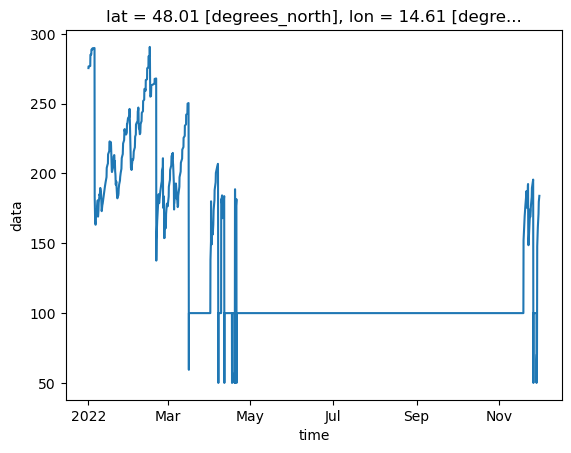

In [10]:
ds.isel(x=520).sel(variable="rsn").data.plot()

In [3]:
x_size = 6
t_size = 7
len_ds = x_size * t_size

for idx in range(len_ds):
    t_idx = idx // x_size
    x_idx = idx % x_size
    print(idx, t_idx, x_idx)


0 0 0
1 0 1
2 0 2
3 0 3
4 0 4
5 0 5
6 1 0
7 1 1
8 1 2
9 1 3
10 1 4
11 1 5
12 2 0
13 2 1
14 2 2
15 2 3
16 2 4
17 2 5
18 3 0
19 3 1
20 3 2
21 3 3
22 3 4
23 3 5
24 4 0
25 4 1
26 4 2
27 4 3
28 4 4
29 4 5
30 5 0
31 5 1
32 5 2
33 5 3
34 5 4
35 5 5
36 6 0
37 6 1
38 6 2
39 6 3
40 6 4
41 6 5


In [3]:
print(ds.sel(variable="sd").data_stdevs.values, ds.sel(variable="swvl1").data_stdevs.values)
print(ds.sel(variable="sd").data_means.values, ds.sel(variable="swvl1").data_means.values)
print(ds.sel(variable="sd").data_1stdiff_stdevs.values, ds.sel(variable="swvl1").data_1stdiff_stdevs.values)

0.1270888 0.16508672
0.012547618 0.24250516
9.928088e-05 0.004012601


In [2]:
test_ds = dm.EcDataset(
    start_yr=2022,
    end_yr=2022,
    # x_idxs=(500, 500 + 1),
    # path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr",
    # x_idxs=(9973, 9973 + 1),
    # path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6H.zarr"
    # path="/ec/res4/hpcperm/daep/ecland_i8ki_o200_2010_2022_1hr.zarr",
    path="/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i8ki_o200_2010_2022_6h.zarr"
)

In [2]:
test_ds.x_static_scaled.shape

NameError: name 'test_ds' is not defined

In [5]:
len(test_ds.static_feat_lst)

20

In [81]:
da = xr.open_dataset("/home/rdx/data/climate/climate.v021/1279_4/slt", engine="cfgrib")
da

Can't create file '/home/rdx/data/climate/climate.v021/1279_4/slt.923a8.idx'
Traceback (most recent call last):
  File "/perm/daep/conda/envs/ml-tt/lib/python3.10/site-packages/cfgrib/messages.py", line 534, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/perm/daep/conda/envs/ml-tt/lib/python3.10/contextlib.py", line 135, in __enter__
    return next(self.gen)
  File "/perm/daep/conda/envs/ml-tt/lib/python3.10/site-packages/cfgrib/messages.py", line 500, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/home/rdx/data/climate/climate.v021/1279_4/slt.923a8.idx'
Can't read index file '/home/rdx/data/climate/climate.v021/1279_4/slt.923a8.idx'
Traceback (most recent call last):
  File "/perm/daep/conda/envs/ml-tt/lib/python3.10/site-packages/cfgrib/messages.py", line 544, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
 

<xarray.Dataset> Size: 132MB
Dimensions:     (values: 6599680)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (values) float64 53MB ...
    longitude   (values) float64 53MB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: values
Data variables:
    slt         (values) float32 26MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-14T08:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [82]:
np.unique(da.slt.values)

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [65]:
list(range(item))

[0, 1, 2, 3, 4, 5, 6, 7]

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [88]:
cat_feat_dic = {"clim_sotype": 8, "clim_tvl": 18, "clim_tvh": 19}
cat_feats = []
for x, item in cat_feat_dic.items():
    feats = test_ds.ds_ecland.clim_data[:, test_ds.clim_index][:, test_ds.static_feat_lst.index(x)]
    encoder = OneHotEncoder(categories=[list(range(item))])
    # encoder = OneHotEncoder()
    cat_feats.append(encoder.fit_transform(feats.reshape(-1, 1)).toarray())

In [94]:
cat_clim=torch.tensor(np.hstack(cat_feats)).reshape(1, test_ds.x_size, -1)

In [97]:
cat2 = torch.tensor(sotype_transform.toarray()).reshape(1, test_ds.x_size, -1)

In [100]:
torch.cat([cat2, cat_clim], dim=-1).shape

torch.Size([1, 47892, 53])

In [45]:
sotype = torch.tensor(test_ds.ds_ecland.clim_data[:, test_ds.clim_index][:, test_ds.static_feat_lst.index("clim_sotype")])

In [39]:
num_classes = 8  # Number of unique categories
one_hot_encoded = F.one_hot(sotype, num_classes=num_classes)

RuntimeError: one_hot is only applicable to index tensor.

In [ ]:
num_classes = 4  # Number of unique categories
one_hot_encoded = F.one_hot(categorical_data, num_classes=num_classes)

In [27]:
cat_feats = list(set(["clim_sotype", "clim_tvl", "clim_tvh"]) & set(test_ds.static_feat_lst))
if len(cat_feats) > 0:
    print("yes")

yes


In [30]:
list(set(test_ds.static_feat_lst) - set(["clim_sotype", "clim_tvl", "clim_tvh"]))

['clim_veg_rsminl',
 'clim_cvl',
 'clim_veg_rsminh',
 'clim_theta_cap',
 'clim_sdfor',
 'clim_veg_covl',
 'clim_cu',
 'clim_veg_z0ml',
 'clim_veg_z0mh',
 'clim_glm',
 'clim_sdor',
 'clim_theta_pwp',
 'clim_clake',
 'clim_ldepth',
 'clim_landsea',
 'clim_geopot',
 'clim_veg_covh',
 'clim_cvh',
 'clim_cell_area',
 'clim_ctype']

In [22]:
any(x in test_ds.static_feat_lst for x in ["clim_sotype", "clim_tvl", "clim_tvh"])

True

In [41]:
cat_feat_dic = {"clim_sotype": 8, "clim_tvl": 23, "clim_tvh": 23}

In [19]:
np.unique(test_ds.ds_ecland.clim_data[:, test_ds.clim_index][:, test_ds.static_feat_lst.index("clim_sotype")])

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [14]:
np.unique(test_ds.ds_ecland.clim_data[slice(*test_ds.x_idxs), test_ds.static_feat_lst.index("clim_tvh")])

array([0.0000000e+00, 7.7941895e-02, 9.7290039e-02, ..., 6.1798279e+02,
       6.3006750e+02, 6.5018146e+02], dtype=float32)

In [4]:
xr.open_zarr("/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h.zarr")

<xarray.Dataset>
Dimensions:                     (x: 187070, clim_variable: 23, time: 18744,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 'clim_cell_area' ... '...
    lat                         (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
    lon                         (x) float32 dask.array<chunksize=(187070,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 2010-02-01 ... 2022-11-...
  * variable                    (variable) object 'met_ctpf' ... 'es'
  * x                           (x) int32 2192 2193 2194 ... 654399 654400
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 dask.array<chunksize=(187070, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 dask.array<chunksize=(4, 187070, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 dask.array<chunksize=(187070, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 dask.array<chunksize=(187070, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 dask.array<chunksize=(23384, 9), meta=np.ndarray>
    global_data_means           (x, variable) float32 dask.array<chunksize=(23384, 9), meta=np.ndarray>
    global_data_mins            (x, variable) float32 dask.array<chunksize=(23384, 9), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 dask.array<chunksize=(23384, 9), meta=np.ndarray>

In [2]:
import torch

In [3]:
torch.__version__

'2.2.1+cu121'

In [6]:
da = xr.open_zarr("/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i8ki_2010_2022_1h.zarr/")
da

<xarray.Dataset> Size: 716GB
Dimensions:                     (x: 47892, clim_variable: 22, time: 113208,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 176B 'clim_cell_area' ...
    lat                         (x) float32 192kB dask.array<chunksize=(47892,), meta=np.ndarray>
    lon                         (x) float32 192kB dask.array<chunksize=(47892,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 906kB 2010-01-01 ... 20...
  * variable                    (variable) object 264B 'met_ctpf' ... 'es'
  * x                           (x) int32 192kB 713 714 715 ... 167199 167200
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 4MB dask.array<chunksize=(47892, 22), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    data                        (time, x, variable) float32 716GB dask.array<chunksize=(24, 47892, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 6MB dask.array<chunksize=(47892, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 6MB dask.array<chunksize=(47892, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 6MB dask.array<chunksize=(11973, 9), meta=np.ndarray>
    global_data_means           (x, variable) float32 6MB dask.array<chunksize=(11973, 9), meta=np.ndarray>
    global_data_mins            (x, variable) float32 6MB dask.array<chunksize=(11973, 9), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 6MB dask.array<chunksize=(11973, 9), meta=np.ndarray>

In [4]:
test_ds = dm.EcDataset(
    start_yr=2022,
    end_yr=2022,
    # x_idxs=(500, 500 + 1),
    # path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr",
    x_idxs=(9973, 9973 + 1),
    # path="/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6H.zarr"
    # path="/ec/res4/hpcperm/daep/ecland_i8ki_o200_2010_2022_1hr.zarr",
    path="/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_2010_2022_6h.zarr"
)

plot_callback = tc.PlotCallback(plot_frequency=CONFIG["logging"]["plot_freq"],
                             dataset=test_ds,
                             device=device,
                             #logger=logger
                             )

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [4]:
import cftime
ds = zarr.open("/ec/res4/scratch/daep/ec_training_db_out_O400/ecland_i6aj_2010_2022_6H.zarr")

date_times = pd.DatetimeIndex(cftime.num2pydate(ds["time"], ds["time"].attrs["units"]))

start_index = min(np.argwhere(date_times.year == int(2014)))[0]
end_index = max(np.argwhere(date_times.year == int(2014)))[0]
start_index, end_index

(5719, 7178)

In [5]:
list(ds["variable"])

['met_ctpf',
 'met_lwdown',
 'met_psurf',
 'met_qair',
 'met_rainf',
 'met_swdown',
 'met_snowf',
 'met_tair',
 'met_wind_e',
 'met_wind_n',
 'lai_hv',
 'lai_lv',
 'd2m',
 'rsn',
 'sd',
 'skt',
 'snowc',
 'sro',
 'ssro',
 'stl1',
 'stl2',
 'stl3',
 'swvl1',
 'swvl2',
 'swvl3',
 't2m',
 'tsn',
 'sshf',
 'slhf']

In [6]:
var = "sd"
true = ds["data"][0:3, :, list(ds["variable"]).index(var)]
pred = ds["data"][4:7, :, list(ds["variable"]).index(var)]

map_errs = np.abs((pred - true) / (true + 1e-5)) * 100
mape = np.mean(map_errs, axis=0)

In [17]:
ds = zarr.open("/ec/res4/scratch/daep/ec_training_db_out_O200/ecland_i8ki_2010_2022_6H.zarr")
ds["time"][:]

array([     0,      6,     12, ..., 105174, 105180, 105186])

In [7]:
mape.shape

(187070,)

In [27]:
def make_map_val_plot(pred_arr, targ_arr, lat_arr, lon_arr, name_lst):
    fig, axes = plt.subplots(
    nrows=3,
    ncols=int(np.ceil(len(name_lst) / 3)),
    figsize=(16, 8),
    )

    map_errs = 100 * np.abs((pred_arr - targ_arr) / (targ_arr + 1e-5))
    mape = np.mean(map_errs, axis=0)

    for i, axis in enumerate(axes.flatten()):
        if i < len(name_lst):
            var = name_lst[i]
            c = axis.scatter(lon_arr[::1], lat_arr[::1], c=mape[::1, name_lst.index(var)], vmin=0, vmax=50, s=1)
            plt.colorbar(c)
            axis.set_title(f"MAPE {var}")
        else:
            axis.set_axis_off()
        
    fig.tight_layout()
    return fig

In [28]:
x = None
x=4
y = 1 if x is None else x

y

4

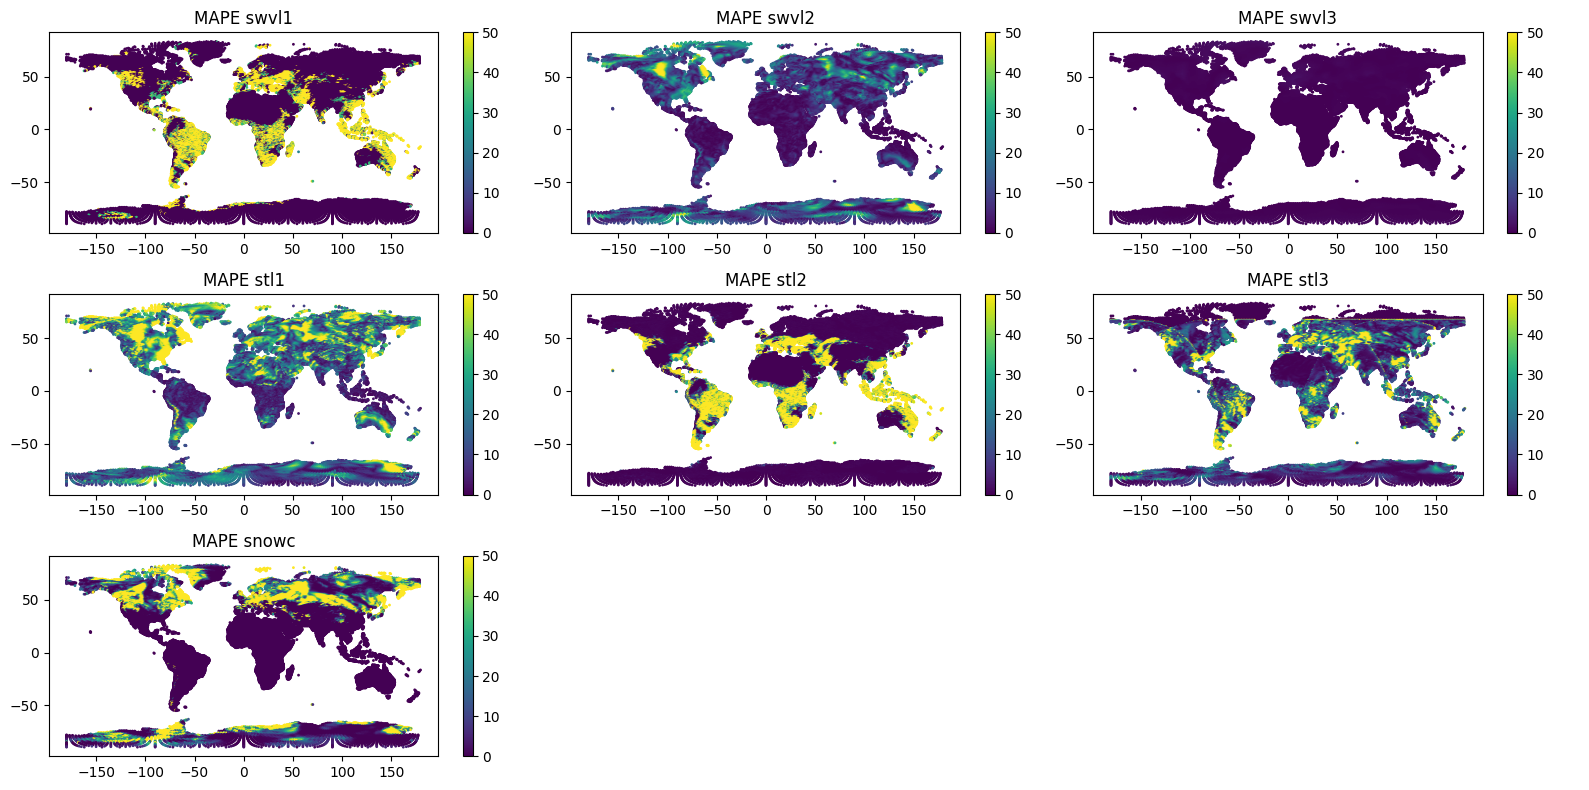

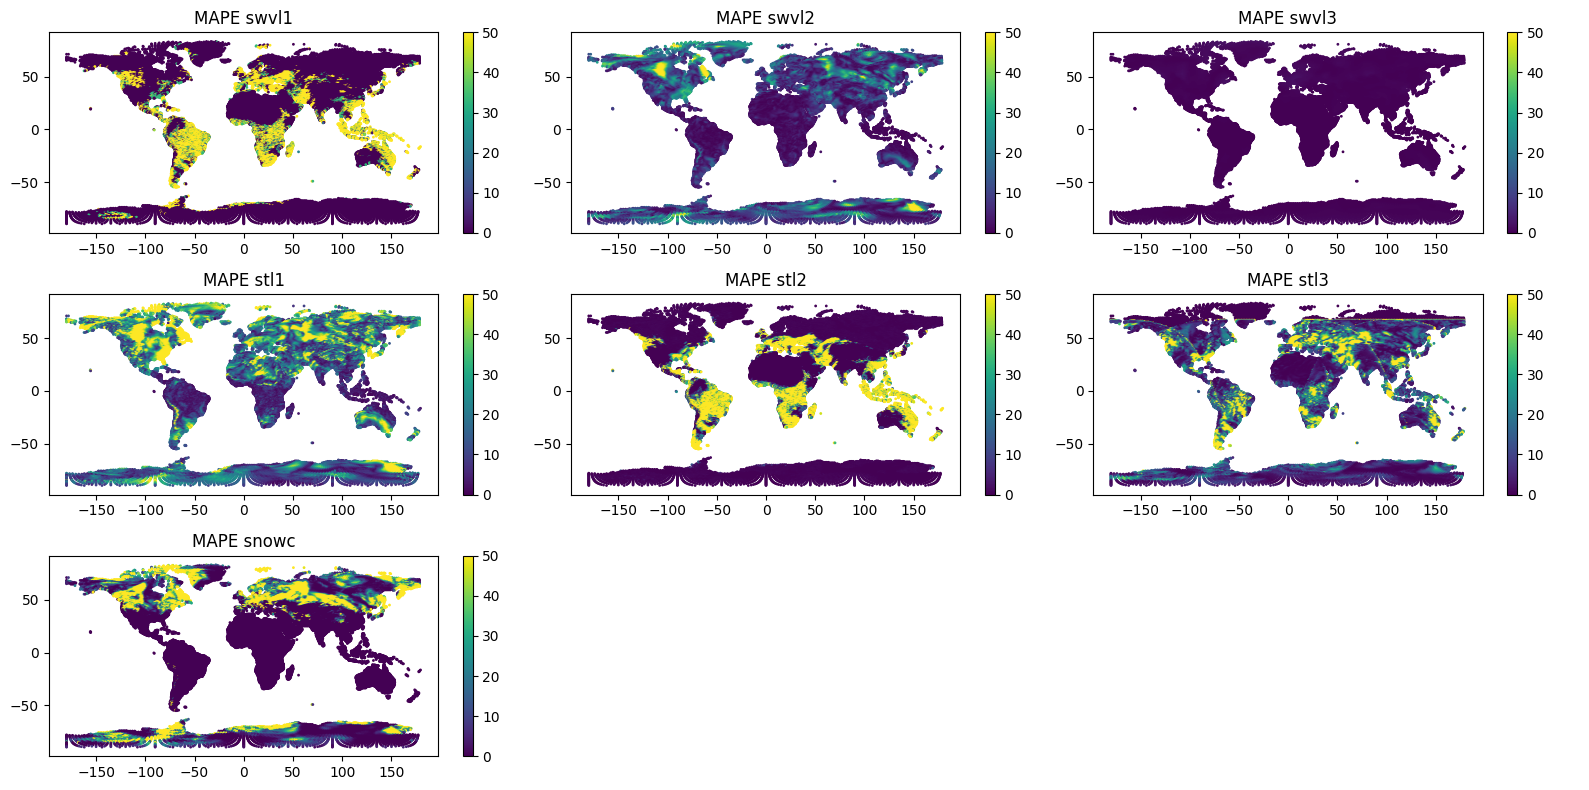

In [29]:
name_lst = ["swvl1", "swvl2", "swvl3", "stl1", "stl2", "stl3", "snowc"]

true = ds["data"][0:3, :, :]
pred = ds["data"][4:7, :, :]
lon = ds["lon"][:]
lat = ds["lat"][:]

make_map_val_plot(pred, true, lat, lon, name_lst)

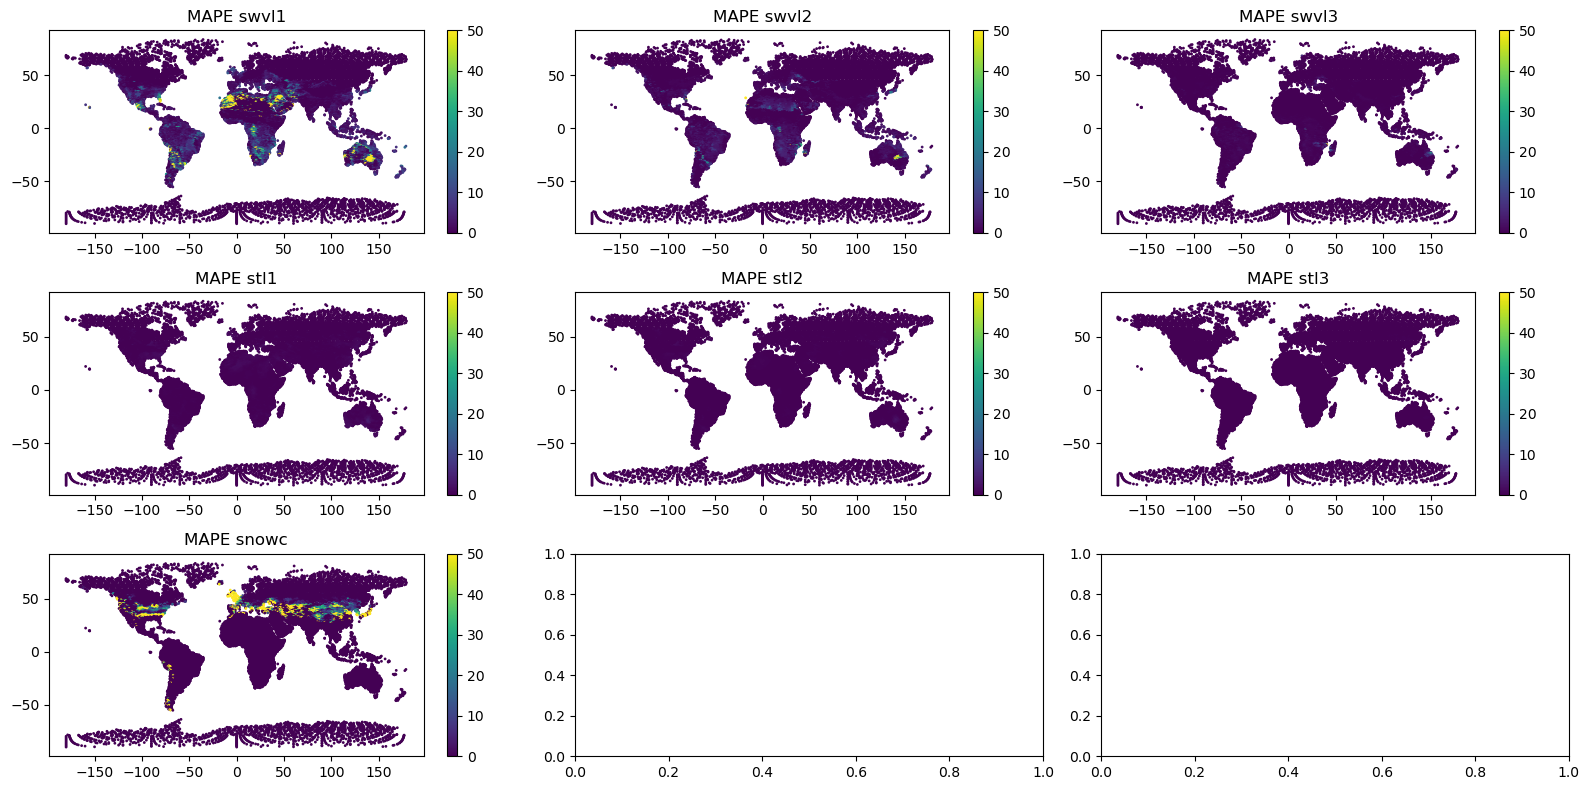

In [40]:
name_lst = ["swvl1", "swvl2", "swvl3", "stl1", "stl2", "stl3", "snowc"]

true = ds["data"][0:3, :, :]
pred = ds["data"][4:7, :, :]
lon = ds["lon"][:]
lat = ds["lat"][:]

fig, axes = plt.subplots(
    nrows=3,
    ncols=int(np.ceil(len(name_lst) / 3)),
    figsize=(16, 8),
)

map_errs = np.abs((pred - true) / (true + 1e-5)) * 100
mape = np.mean(map_errs, axis=0)

for i, var in enumerate(name_lst):
    c = axes.flatten()[i].scatter(lon[::10], lat[::10], c=mape[::10, list(ds["variable"]).index(var)], vmin=0, vmax=50, s=1)
    plt.colorbar(c)
    axes.flatten()[i].set_title(f"MAPE {var}")
    
fig.tight_layout()

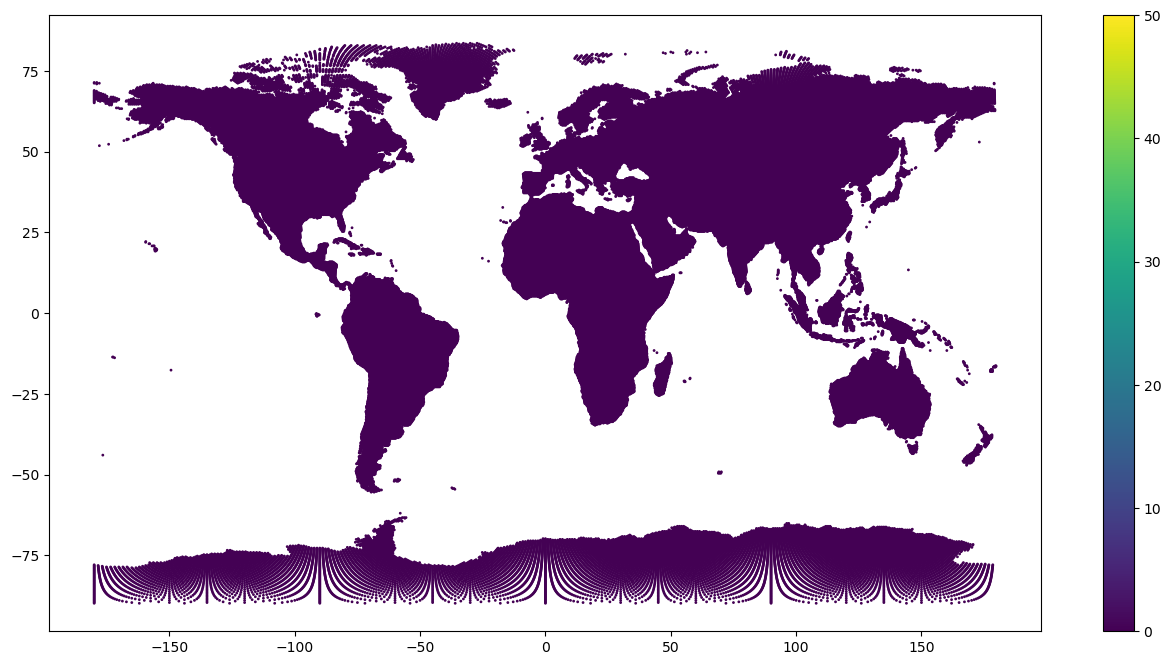

In [34]:
plt.figure(figsize=(16,8))
c = plt.scatter(ds["lon"][:], ds["lat"][:], c=mape, vmin=0, vmax=50, s=1)
plt.colorbar(c)

In [3]:
ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
start_yr = 2021
end_yr = 2021
hours_series = pd.Series(ds["time"])
start_date = pd.to_datetime(dict(ds["time"].attrs)["units"][-10:])
date_times = start_date + pd.to_timedelta(hours_series, unit="h")
# date_times = pd.DatetimeIndex(cftime.num2pydate(self.ds_ecland["time"], self.ds_ecland["time"].attrs["units"]))
start_index = min(np.argwhere(date_times.dt.year == int(start_yr)))[0]
end_index = max(np.argwhere(date_times.dt.year == int(end_yr)))[0]
times = np.array(date_times[start_index: end_index])
len_dataset = end_index - start_index

In [4]:
ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
date_times2 = pd.to_datetime(cftime.num2pydate(ds["time"], ds["time"].attrs["units"]))
start_index2 = min(np.argwhere(date_times2.year == int(start_yr)))[0]
end_index2 = max(np.argwhere(date_times2.year == int(end_yr)))[0]
times2 = np.array(date_times2[start_index2: end_index2])
len_dataset2 = end_index2 - start_index2

In [5]:
start_index, start_index2

(15948, 15948)

In [6]:
times - times2

array([0, 0, 0, ..., 0, 0, 0], dtype='timedelta64[ns]')

In [7]:
times2

array(['2021-01-01T00:00:00.000000000', '2021-01-01T06:00:00.000000000',
       '2021-01-01T12:00:00.000000000', ...,
       '2021-12-31T00:00:00.000000000', '2021-12-31T06:00:00.000000000',
       '2021-12-31T12:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
dataset = dm.EcDataset(start_yr=2021, 
                       end_yr=2021, 
                       #x_idxs=(31794, 31794+1),
                       x_idxs=(0, "None"),
                       path="/ec/res4/scratch/daep/ec_training_db_out_O400/ecland_i6aj_2010_2022_6H.zarr"
                      )

In [9]:
clim, met, prog, inc, diag = dataset[1]

In [23]:
dataset.y_diag_means, dataset.y_diag_stdevs

(tensor([275.4097,  32.7241,  43.4570]), tensor([18.7539, 93.2076, 86.1992]))

In [10]:
dataset.targ_diag_lst

['d2m', 'sshf', 'slhf']

In [16]:
np.max(diag[:,:,2].numpy())

11.036693

In [22]:
idx=2
np.min(diag[:,slice(31294, 32294),idx].numpy()), np.max(diag[:,slice(31294, 32294),idx].numpy())

(-0.7340147, 2.0984168)

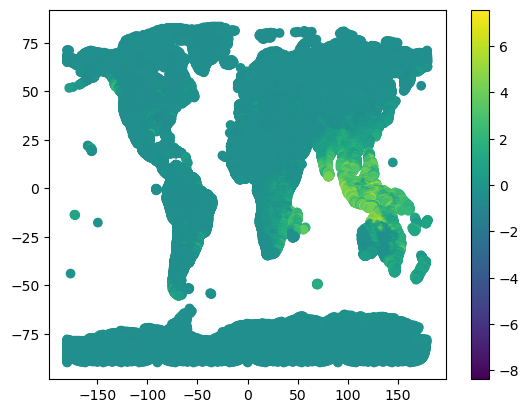

In [12]:
c = plt.scatter(dataset.lons, dataset.lats, c=diag[0,:,2])
plt.colorbar(c)

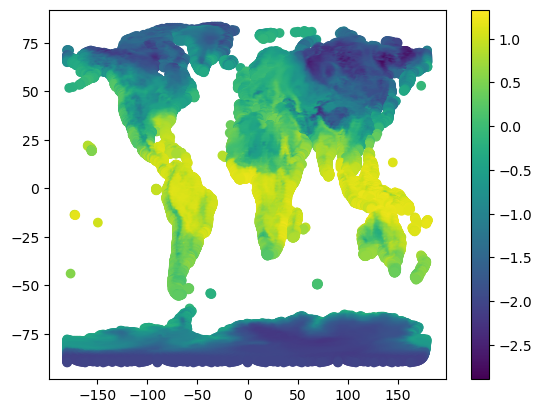

In [24]:
c = plt.scatter(dataset.lons, dataset.lats, c=diag[0,:,0])
plt.colorbar(c)

In [10]:
clim, met, prog, diag = dataset.load_data()

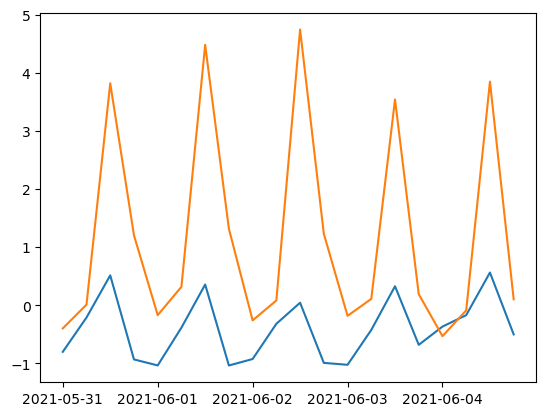

In [25]:
strt=4*150
plt.plot(dataset.times[strt:strt+4*5],diag.numpy()[strt:strt+4*5,0,0])
plt.plot(dataset.times[strt:strt+4*5],diag.numpy()[strt:strt+4*5,0,1])

In [ ]:
clim, met, prog, diag = dataset.load_data()
for x in [clim, met, prog, inc, diag]:
    print(np.sum(np.isnan(x.numpy())))

In [5]:
# dataset = dm.EcDataset(start_yr=2022, end_yr=2022, x_idxs=(38582, 38582+1))
dataset = dm.EcDataset(start_yr=2022, end_yr=2022, x_idxs=(500, 500+1), path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
# dataset = dm.EcDataset(start_yr=2022, end_yr=2022, path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")

In [8]:
dataset.dynamic_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [3]:
dataset.ds_ecland.lat[500], dataset.ds_ecland.lon[500] 

(48.007484, 5.183246)

In [4]:
#ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i8ki_o200_2010_2022_1hr.zarr")
ds

<xarray.Dataset> Size: 651GB
Dimensions:                (x: 47892, clim_variable: 22, time: 113208,
                            variable: 30)
Coordinates:
  * clim_variable          (clim_variable) object 176B 'clim_cell_area' ... '...
    lat                    (x) float32 192kB dask.array<chunksize=(47892,), meta=np.ndarray>
    lon                    (x) float32 192kB dask.array<chunksize=(47892,), meta=np.ndarray>
  * time                   (time) datetime64[ns] 906kB 2010-01-01 ... 2022-11...
  * variable               (variable) object 240B 'met_ctpf' ... 'slhf'
  * x                      (x) int32 192kB 713 714 715 ... 167198 167199 167200
Data variables:
    clim_data              (x, clim_variable) float32 4MB dask.array<chunksize=(47892, 22), meta=np.ndarray>
    clim_means             (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    clim_stdevs            (clim_variable) float32 88B dask.array<chunksize=(22,), meta=np.ndarray>
    data                   (time, x, variable) float32 651GB dask.array<chunksize=(24, 47892, 30), meta=np.ndarray>
    data_means             (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    data_stdevs            (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    firstdiff_means        (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    firstdiff_stdevs       (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    norm_firstdiff_means   (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>
    norm_firstdiff_stdevs  (variable) float32 120B dask.array<chunksize=(30,), meta=np.ndarray>

In [10]:
idx = find_nearest_idx(ds.lat.values, ds.lon.values, 48.007484, 5.18324)
print(ds.lat.values[idx], ds.lon.values[idx])
idx

47.86512 5.5102043


9973

In [10]:
da=xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out_O200/ecland3_i8ki_2010_2010_1H.zarr")#.sel(time="2010-02")
da2=xr.open_zarr("/ec/res4/scratch/daep/ec_training_db_out_O200/i8ki_20100201.zarr")

#da.sshf.values

def deacc_flux(da):
    flux_acc = da.values
    flux = np.zeros_like(flux_acc)
    flux[1::24] = flux_acc[1::24]
    for i in range(2, 24):
        #print(i)
        flux[i::24] = flux_acc[i::24] - flux_acc[i-1::24]
    #flux[23::24] = flux_acc[23::24] - flux_acc[22::24]
    flux[24::24] = np.mean([flux[25::24], flux[23::24][:-1]], axis=0)
    return flux
    
da2["sshf"][:] = deacc_flux(da2.sshf)

In [11]:
list(da2.data_vars)

['aco2gpp',
 'asn',
 'clim_CLAKE',
 'clim_Ctype',
 'clim_LDEPTH',
 'clim_cell_area',
 'clim_cu',
 'clim_cvh',
 'clim_cvl',
 'clim_geopot',
 'clim_glm',
 'clim_landsea',
 'clim_lz0h',
 'clim_sdfor',
 'clim_sdor',
 'clim_seaice',
 'clim_sotype',
 'clim_sst',
 'clim_theta_cap',
 'clim_theta_pwp',
 'clim_tvh',
 'clim_tvl',
 'clim_veg_covh',
 'clim_veg_covl',
 'clim_veg_rsminh',
 'clim_veg_rsminl',
 'clim_veg_z0mh',
 'clim_veg_z0ml',
 'clim_z0m',
 'd2m',
 'dis',
 'e',
 'es',
 'fal',
 'fldsto',
 'lai_hv',
 'lai_lv',
 'lwcs_l1',
 'lwcs_l2',
 'lwcs_l3',
 'lwcs_l4',
 'lwcs_l5',
 'rsn',
 'rsn_l1',
 'rsn_l2',
 'rsn_l3',
 'rsn_l4',
 'rsn_l5',
 'sd',
 'sd_l1',
 'sd_l2',
 'sd_l3',
 'sd_l4',
 'sd_l5',
 'skt',
 'slhf',
 'snowc',
 'sro',
 'sshf',
 'ssro',
 'stl1',
 'stl2',
 'stl3',
 'stl4',
 'swvl1',
 'swvl2',
 'swvl3',
 'swvl4',
 't2m',
 'tsn',
 'tsn_l1',
 'tsn_l2',
 'tsn_l3',
 'tsn_l4',
 'tsn_l5']

In [13]:
flux_acc = ds.isel(x=idx).sel(time="2010-02", variable="sshf").data.values
flux2=np.diff(flux_acc, n=1)

flux=np.zeros_like(flux_acc)
flux[1::24] = flux_acc[1::24]
for i in range(2, 24):
    #print(i)
    flux[i::24] = flux_acc[i::24] - flux_acc[i-1::24]
#flux[23::24] = flux_acc[23::24] - flux_acc[22::24]
flux[24::24] = np.mean([flux[25::24], flux[23::24][:-1]], axis=0)

In [14]:
np.mean([flux[25::24], flux[23::24][:-1]], axis=0)

array([130907.25 , 221322.   , 168351.25 ,  96863.   ,  49462.875,
        38997.375,   8377.5  ,  35013.5  ,  16345.625,  12359.5  ,
        18118.25 ,  12905.625,  17700.625,   8356.25 ,  32469.   ,
       155892.62 ,  81686.375,  65389.875,  66639.5  ,  65502.625,
        74604.75 , 266166.5  ,  12369.875,  78045.5  , 279042.75 ,
       435739.25 , 258897.75 ], dtype=float32)

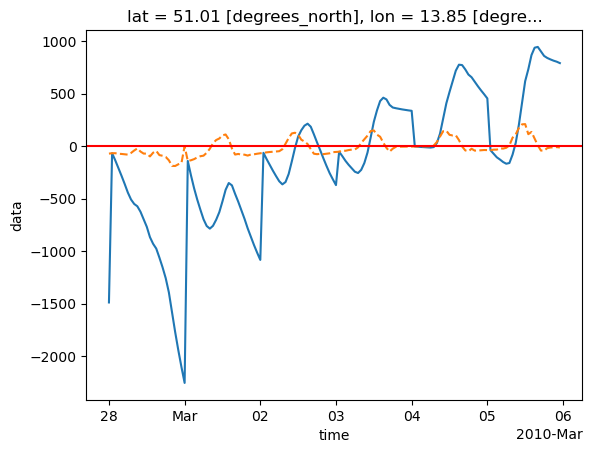

In [15]:
(ds.isel(x=idx).sel(time=slice("2010-02-28", "2010-03-05"), variable="sshf")/(3600*1)*-1).data.plot()
#plt.plot(ds.sel(time=slice("2010-01-01 00:00", "2010-01-05 00:00")).time.values, flux2[:24*4+1])
#plt.plot(ds.sel(time="2010-02").time.values, flux[:]/(3600*1)*-1)
da.sel(time=slice("2010-02-28", "2010-03-05"), variable="sshf").isel(x=idx).data.plot(linestyle='--')
#(da2.isel(x=idx).sshf/(3600*1)*-1).plot()
plt.axhline(y=0.0, color='r', linestyle='-')

In [ ]:
(ds.isel(x=idx).sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00"), variable="sshf").data/(3600*1)*-1).plot()
#plt.plot(ds.sel(time=slice("2010-01-01 00:00", "2010-01-05 00:00")).time.values, flux2[:24*4+1])
plt.plot(ds.sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).time.values, flux[:24*8+1]/(3600*1)*-1)
(da.isel(x=idx).sel(variable="sshf").sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).sshf/(3600*1)*-1).plot()
plt.axhline(y=0.0, color='r', linestyle='--')

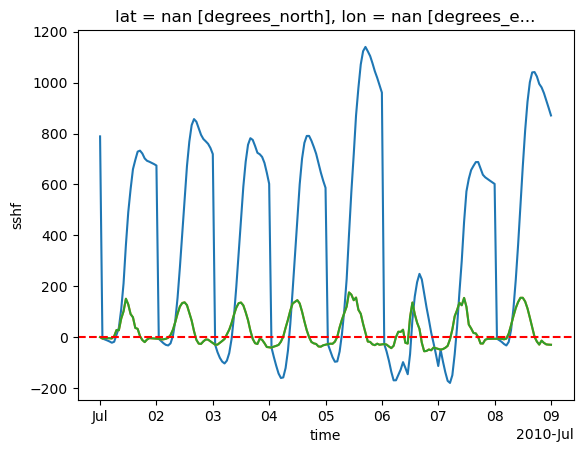

In [99]:
(ds.isel(x=idx).sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00"), variable="sshf").data/(3600*1)*-1).plot()
#plt.plot(ds.sel(time=slice("2010-01-01 00:00", "2010-01-05 00:00")).time.values, flux2[:24*4+1])
plt.plot(ds.sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).time.values, flux[:24*8+1]/(3600*1)*-1)
(da2.isel(x=idx).sel(time=slice("2010-07-01 00:00", "2010-07-09 00:00")).sshf/(3600*1)*-1).plot()
plt.axhline(y=0.0, color='r', linestyle='--')

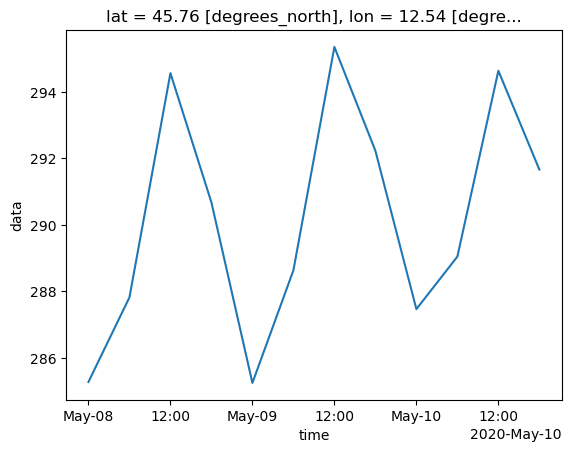

In [153]:
ds.isel(x=42996).sel(time=slice("2020-05-08", "2020-05-10"), variable="t2m").data.plot()

In [132]:
ds.isel(x=idx).sel(time="2020-01", variable="slhf").data.shape

(124,)

In [133]:
np.arange(124)[0::4]

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120])

In [134]:
flux_acc = ds.isel(x=idx).sel(time="2020-07", variable="sshf").data.values
flux=np.zeros(123)

#flux[0::4] = flux_acc[0::4]
flux[0::4] = flux_acc[1::4] - flux_acc[0::4]
flux[1::4] = flux_acc[2::4] - flux_acc[1::4]
flux[2::4] = flux_acc[3::4] - flux_acc[2::4]
flux[3::4] = flux_acc[4::4] - flux_acc[6::4]
#flux[3::4] = flux_acc[4::4] - flux_acc[3::4]

In [135]:
flux_acc = ds.isel(x=idx).sel(time="2020-07", variable="sshf").data.values
flux2=np.diff(flux_acc, n=1)

#flux2[0::4] = flux_acc[0::4]
#flux[1::4] = flux_acc[1::4] - flux_acc[0::4]
#flux[2::4] = flux_acc[2::4] - flux_acc[1::4]
#flux[3::4] = flux_acc[3::4] - flux_acc[2::4]

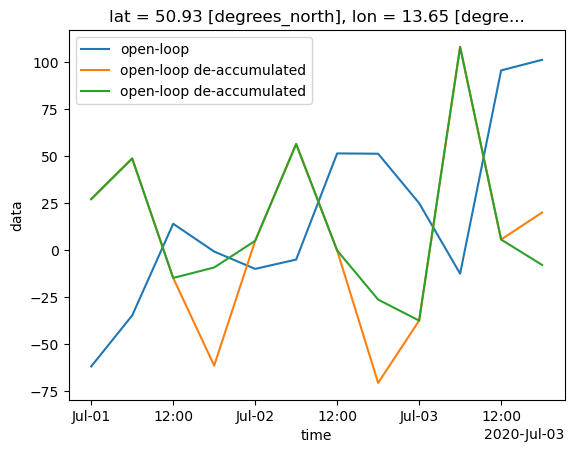

In [136]:
(ds.isel(x=idx).sel(time=slice("2020-07-01", "2020-07-03"), variable="sshf").data/(3600*6)*-1).plot(label="open-loop")
plt.plot(ds.sel(time=slice("2020-07-01", "2020-07-03")).time.values, flux[:4*3]/(3600*6)*-1, label="open-loop de-accumulated")
plt.plot(ds.sel(time=slice("2020-07-01", "2020-07-03")).time.values, flux2[:4*3]/(3600*6)*-1, label="open-loop de-accumulated")
plt.legend()

In [139]:
ds.time.values

array(['2010-02-01T00:00:00.000000000', '2010-02-01T06:00:00.000000000',
       '2010-02-01T12:00:00.000000000', ...,
       '2022-11-30T06:00:00.000000000', '2022-11-30T12:00:00.000000000',
       '2022-11-30T18:00:00.000000000'], dtype='datetime64[ns]')

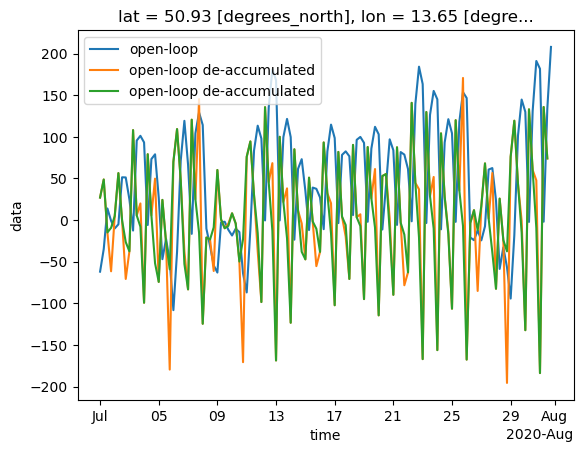

In [138]:
(ds.isel(x=idx).sel(time="2020-07", variable="sshf").data/(3600*6)*-1).plot(label="open-loop")
plt.plot(ds.sel(time="2020-07").time.values[:-1], flux[:]/(3600*6)*-1, label="open-loop de-accumulated")
plt.plot(ds.sel(time="2020-07").time.values[:-1], flux2[:]/(3600*6)*-1, label="open-loop de-accumulated")
plt.legend()

In [106]:
first_diff = ds.data.diff(dim="time")
mus_firstdiff = first_diff.mean(dim=("time", "x")).compute()
stds_firstdiff = first_diff.std(dim=("time", "x")).compute()
mus_firstdiff

<xarray.DataArray 'data' (variable: 30)> Size: 120B
array([ 1.1162232e-06,  1.3758690e-03,  2.0887271e-02,  2.4786832e-08,
       -3.9536065e-11, -1.4714831e-03,  1.4872111e-09,  2.5367574e-04,
       -2.7878968e-05, -6.4790888e-06,  2.0899078e-07,  1.0403950e-06,
        1.8386089e-04,  7.1670959e+01, -2.0612911e-03, -1.2486890e-06,
        3.6287110e-04, -1.6552709e-03, -4.3772239e-09, -6.2628254e-09,
        1.6013796e-04,  1.9426503e-04,  3.2401795e-04, -7.5599104e-07,
        3.7401659e-08, -1.1009563e-06,  2.9975441e-04,  1.7797691e-04,
        4.8517483e-01, -1.7034060e+01], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [30]:
(stds_firstdiff/(ds.data_stdevs+1e-5)).compute()

<xarray.DataArray (variable: 30)> Size: 120B
array([8.5597825e-01, 2.3779385e-01, 2.1496968e-02, 1.2636486e-01,
       6.2359262e-01, 1.1059271e+00, 8.4493643e-01, 1.8103145e-01,
       4.9127263e-01, 5.1590425e-01, 8.0265431e-03, 7.6786629e-03,
       1.4182447e-01, 1.1928137e-01, 1.3556583e-01, 3.0183286e-04,
       3.5703230e-01, 7.8410715e-02, 4.0551847e-01, 3.8227159e-01,
       1.9901708e-01, 4.1306343e-02, 5.7829935e-03, 7.2182857e-02,
       2.5501577e-02, 5.3810431e-03, 2.3832750e-01, 1.7928387e-01,
       6.5720344e-01, 7.9437369e-01], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [28]:
stds_norm_firstdiff

<xarray.DataArray (variable: 30)> Size: 120B
array([8.55978191e-01, 2.37793848e-01, 2.14969683e-02, 1.26364842e-01,
       6.23592436e-01, 1.10592699e+00, 8.44936669e-01, 1.81031451e-01,
       4.91272628e-01, 5.15904248e-01, 8.02663248e-03, 7.67863076e-03,
       1.41824469e-01, 1.19281314e-01, 1.35565802e-01, 3.01832886e-04,
       3.57032299e-01, 7.84107223e-02, 4.05518204e-01, 3.82271439e-01,
       1.99017063e-01, 4.13063392e-02, 5.78299351e-03, 7.21828490e-02,
       2.55015753e-02, 5.38104214e-03, 2.38327503e-01, 1.79283857e-01,
       6.57203436e-01, 7.94373631e-01], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [27]:
data_norm = transform(ds.data, ds.data_means, ds.data_stdevs)
norm_first_diff = data_norm.diff(dim="time")
mus_norm_firstdiff = norm_first_diff.mean(dim=("time", "x"))  #.compute()
stds_norm_firstdiff = norm_first_diff.std(dim=("time", "x"))  #.compute()
mus_norm_firstdiff, stds_norm_firstdiff = dask.compute(*[mus_norm_firstdiff, stds_norm_firstdiff])
mus_norm_firstdiff

<xarray.DataArray (variable: 30)> Size: 120B
array([ 4.89124022e-06,  1.51358945e-05,  2.12957048e-06,  4.18581385e-06,
       -3.66437661e-07, -6.09358358e-06,  5.06774159e-05,  1.26138430e-05,
       -1.00719808e-05, -2.43380327e-06,  1.05915191e-07,  8.79128663e-07,
        9.81306130e-06,  2.93777390e-07, -2.69940429e-05, -4.21450693e-07,
        1.61431290e-05, -4.19172648e-05, -2.41230441e-06, -4.35471657e-06,
        7.99126428e-06,  9.98199812e-06,  1.69885461e-05, -4.73973978e-06,
        2.56129141e-07, -7.72487419e-06,  1.46245320e-05,  1.63634522e-05,
        1.62899354e-07, -5.15793135e-06], dtype=float32)
Coordinates:
  * variable  (variable) object 240B 'met_ctpf' 'met_lwdown' ... 'sshf' 'slhf'

In [ ]:
ds.data.sel(variable="sshf", time="2020-01-02").isel(x=500).plot()

In [4]:
#%%time
#clim, met, state, diagnostic = dataset.load_data()

CPU times: user 1.41 s, sys: 189 ms, total: 1.6 s
Wall time: 10.3 s


In [5]:
from model import NonLinearRegression

input_clim_dim = len(dataset.static_feat_lst)
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
output_diag_dim = len(dataset.targ_diag_lst)
hidden_dim = 90  # CONFIG["hidden_dim"]  # Number of hidden units
model_pyt = NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    output_diag_dim,
)

#mod_path = "mlruns/757456673603942541/1eb5671afb2c44efb573cb9e92ef8d44/checkpoints/epoch=62-step=57519.ckpt"
#model_pyt.load_state_dict(torch.load(mod_path))["state_dict"])

mod_path = "models/pyt_mlf.pt"
model_pyt.load_state_dict(torch.load(mod_path))

<All keys matched successfully>

In [6]:
np.array(dataset.times)[0]

numpy.datetime64('2022-01-01T00:00:00.000000000')

CPU times: user 1.48 s, sys: 161 ms, total: 1.64 s
Wall time: 1.55 s


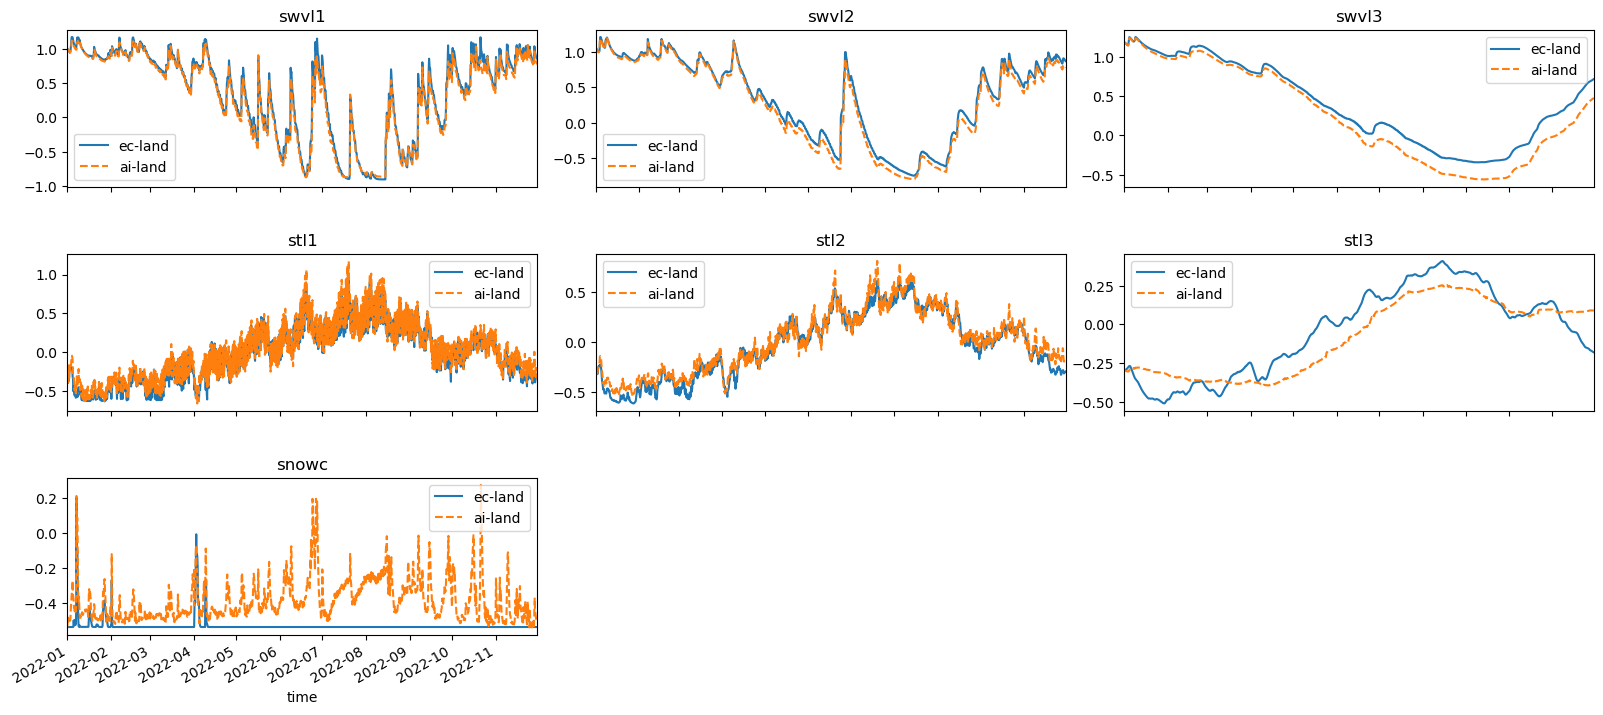

In [8]:
%%time
plot_class = tc.PlotCallback(2, dataset)
plot_class.make_subplot(model_pyt, 2)

In [ ]:
%%time
with torch.no_grad():
    preds, preds_diag = model_pyt.predict_step(clim, met, state, diagnostic)

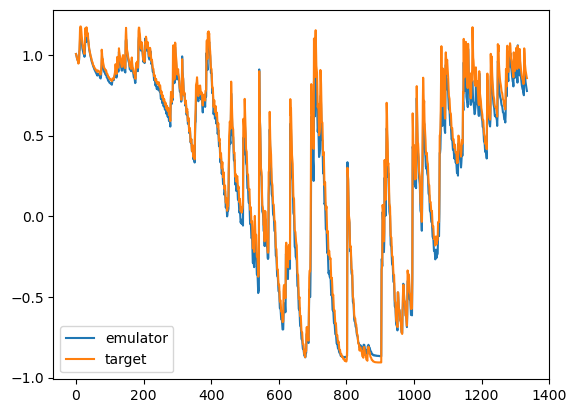

In [11]:
idx = 0
ll_idx = 500
plt.plot(preds[:, ll_idx, idx].detach().numpy(), label="emulator")
plt.plot(state[:, ll_idx, idx].detach().numpy(), label="target")
plt.legend()

In [ ]:
ds

In [2]:
x_idxs=[0, "None"]
#x_idxs=2
x = (0, None) if "None" in x_idxs else x_idxsdata_module

In [3]:
x

(0, None)

In [3]:
%%time
ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")

# Convert the list of hours to a pandas Series
hours_series = pd.Series(ds["time"])
# Create a datetime index starting from 2010-01-01
start_date = pd.to_datetime(dict(ds["time"].attrs)["units"][-10:])
date_times = start_date + pd.to_timedelta(hours_series, unit='h')
date_times

CPU times: user 14.5 ms, sys: 72.9 ms, total: 87.4 ms
Wall time: 4.28 s


0       2010-02-01 00:00:00
1       2010-02-01 06:00:00
2       2010-02-01 12:00:00
3       2010-02-01 18:00:00
4       2010-02-02 00:00:00
                ...        
18739   2022-11-29 18:00:00
18740   2022-11-30 00:00:00
18741   2022-11-30 06:00:00
18742   2022-11-30 12:00:00
18743   2022-11-30 18:00:00
Length: 18744, dtype: datetime64[ns]

In [14]:
list(ds)

['clim_data',
 'clim_means',
 'clim_stdevs',
 'clim_variable',
 'data',
 'data_means',
 'data_stdevs',
 'firstdiff_means',
 'firstdiff_stdevs',
 'lat',
 'lon',
 'time',
 'variable',
 'x']

In [63]:
start_index = min(np.argwhere(date_times.dt.year==int(CONFIG["start_year"])))
end_index = max(np.argwhere(date_times.dt.year==int(CONFIG["end_year"])))
len_dataset = end_index - start_index
print(start_index, end_index, len_dataset)

[8640] [17407] [8767]


In [94]:
x_idxs=(0, 10 + 4 +1)
ds.x[slice(0, 10 + 4 +1)]

array([2192, 2193, 2194, 2195, 2326, 2327, 2328, 2329, 2330, 2331, 2464,
       2465, 2466, 2467, 2468], dtype=int32)

In [79]:
%%time
clim_index = [list(ds["clim_variable"]).index(x) for x in CONFIG["clim_feats"]]
clim_index

CPU times: user 8.21 ms, sys: 3.49 ms, total: 11.7 ms
Wall time: 22 ms


[10, 9, 12, 0, 13, 11, 3, 2, 1, 8, 7, 15, 14, 19, 18, 21, 20, 17, 16]

In [65]:
ds["clim_data"].shape

(187070, 22)

In [12]:
%%time
ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
ds["data"][0]

CPU times: user 43.5 ms, sys: 83.9 ms, total: 127 ms
Wall time: 70.4 ms


array([[0.0000000e+00, 1.8028931e+02, 9.6036438e+04, ..., 2.5036263e+02,
        8.6097600e+05, 5.1504000e+04],
       [0.0000000e+00, 1.7871770e+02, 9.6024961e+04, ..., 2.4987630e+02,
        1.0522600e+06, 6.7132000e+04],
       [0.0000000e+00, 1.7103931e+02, 9.8091852e+04, ..., 2.4932454e+02,
        1.0861920e+06, 5.8864000e+04],
       ...,
       [0.0000000e+00, 1.6743513e+02, 6.9658438e+04, ..., 2.3532845e+02,
        6.2912800e+05, 4.7124000e+04],
       [0.0000000e+00, 1.7016040e+02, 6.9632406e+04, ..., 2.3547591e+02,
        6.6218000e+05, 5.0508000e+04],
       [0.0000000e+00, 1.7058357e+02, 6.9566375e+04, ..., 2.3554622e+02,
        7.1256000e+05, 5.5300000e+04]], dtype=float32)

In [15]:
%%time
ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
#ds.data_vars
ds.data.data[0]

CPU times: user 18.8 ms, sys: 24.7 ms, total: 43.4 ms
Wall time: 284 ms


dask.array<getitem, shape=(187070, 30), dtype=float32, chunksize=(187070, 30), chunktype=numpy.ndarray>

In [16]:
def reset_chunk_encoding(da: xr.Dataset) -> xr.Dataset:
    """resets previous chunk encoding on concatenated zarr stores

    :param da: Dataset
    :return: Dataset with reset chunk encoding
    """
    for x in da.coords:
        if "chunks" in da[x].encoding.keys():
            #logging.info(f"deleting chunk encoding for {x}...")
            del da[x].encoding["chunks"]
        if da.coords[x].dtype == object:
            da[x].encoding.clear()

    for var in da:
        if "chunks" in da[var].encoding.keys():
            #logging.info(f"deleting chunk encoding for {var}...")
            del da[var].encoding["chunks"]
        if da[x].dtype == object:
            da[x].encoding.clear()
    return da


ds = reset_chunk_encoding(ds.isel(x=slice(38582-500, 38582+500)))
# ds.to_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")

In [19]:
list(ds.variable.values)

['met_ctpf',
 'met_lwdown',
 'met_psurf',
 'met_qair',
 'met_rainf',
 'met_swdown',
 'met_snowf',
 'met_tair',
 'met_wind_e',
 'met_wind_n',
 'lai_hv',
 'lai_lv',
 'd2m',
 'dis',
 'rsn',
 'sd',
 'skt',
 'snowc',
 'sro',
 'ssro',
 'stl1',
 'stl2',
 'stl3',
 'swvl1',
 'swvl2',
 'swvl3',
 't2m',
 'tsn',
 'sshf',
 'slhf']

In [31]:
%%time
VAR="met_snowf"

ds = zarr.open("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
latlon_idx = find_nearest_idx(ds["lat"][:], ds["lon"][:], 48, 5)
latlon_idx

# Convert the list of hours to a pandas Series
hours_series = pd.Series(ds["time"])
# Create a datetime index starting from 2010-01-01
start_date = pd.to_datetime(dict(ds["time"].attrs)["units"][-10:])
date_times = start_date + pd.to_timedelta(hours_series, unit='h')
start_index = min(np.argwhere(date_times.dt.year==2016))[0]
end_index = max(np.argwhere(date_times.dt.year==2022))[0]
len_dataset = end_index - start_index
print(start_index, end_index, len_dataset)

print(latlon_idx, ds["lat"][latlon_idx], ds["lon"][latlon_idx])
dat_arr = ds["data"][0+start_index:200+start_index, latlon_idx, list(ds["variable"]).index(VAR)]
# dat_arr = ds["data"][:, latlon_idx, list(ds["variable"]).index(VAR)]

8640 18743 10103
38582 48.007484 5.183246
CPU times: user 1.66 s, sys: 4.11 s, total: 5.77 s
Wall time: 2.93 s


In [27]:
ds = xr.open_zarr("/perm/daep/ec_land_db_test/ecland_i6aj_2016_2022_europe.zarr")
latlon_idx = find_nearest_idx(ds["lat"][:], ds["lon"][:], 48, 5)
latlon_idx
print(ds["lat"].values[latlon_idx], ds["lon"].values[latlon_idx])
dat_xr = ds[VAR].values[0:200, latlon_idx]

48.007484 5.183243


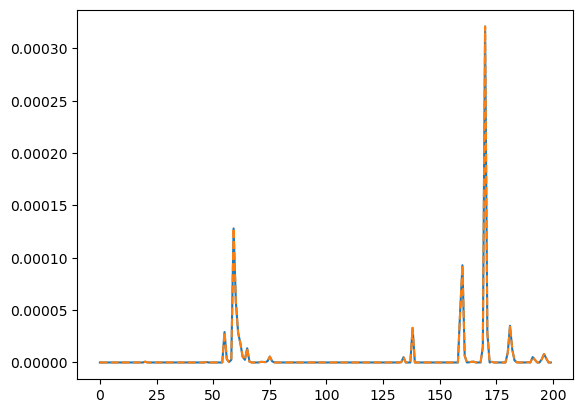

In [28]:
plt.plot(dat_arr)
plt.plot(dat_xr, '--')